In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_convection_with_ROE(a=0, b=1000, N=300, CFL=0.6, Tfinal=10):
    # Paramètres du domaine
    dx = (b - a) / (N - 1)
    x = np.linspace(a, b, N)

    # Initialisation de la solution u et h
    u = np.zeros(N)
    h = np.zeros(N)
    q = np.zeros(N)
    unewx=np.zeros(N)
    hnewx=np.zeros(N)
    qnewx=np.zeros(N)
    unewp=np.zeros(N)
    hnewp=np.zeros(N)
    qnewp=np.zeros(N)

    # Fonction pour la condition initiale de la hauteur h (rupture du barrage)
    def f(x):
        if 0 <= x <= 500:
            return 5 # Hauteur de l'eau avant la rupture
        else:
            return 0  # Hauteur de l'eau après la rupture

    # Initialisation de la condition initiale
    for i in range(N):
        h[i] = f(x[i])

    g = 9.81  # Accélération due à la gravité
    temps = 0

    while temps < Tfinal:
        # Calcul du pas de temps pour assurer la stabilité
        s_1 = np.abs(u + np.sqrt(g * h))
        s_2 = np.abs(u - np.sqrt(g * h))
        S_1max = max(s_1)
        S_2max = max(s_2)
        max_u = max(S_1max, S_2max)

        dt = CFL * dx / max_u
        lamda = dt / dx
        #mise a jour solution exacte 
        for i in range(N):
            if x[i]<=(500-temps*np.sqrt(g*5)):
                hnewx[i]= 5
                unewx[i]= 0
            
            elif (500-temps*np.sqrt(g*5))<x[i]<(500+2*temps*np.sqrt(g*5)):
                unewx[i]= (2/3)*(np.sqrt(g*5)+(x[i]-500)/temps)
                hnewx[i]= (1/(9*g))*((2*np.sqrt(g*5)-(x[i]-500)/temps)**2)
            else:
                hnewx[i]=0
                unewx[i]=0

        # Mise à jour de la solution numérique
        for i in range(1, N - 1):
            h_tild_r = (h[i] + h[i + 1]) / 2
            if h[i] == 0 and h[i + 1] == 0:
                u_tild_r = 0
            else:
                u_tild_r = ((np.sqrt(h[i]) * u[i] + np.sqrt(h[i + 1]) * u[i + 1]) / (np.sqrt(h[i]) + np.sqrt(h[i + 1])))

            y = np.zeros(2)
            P = np.ones((2, 2))
            D = np.zeros((2, 2))
            PI = np.ones((2, 2))

            y[0] = h[i + 1] - h[i]
            y[1] = h[i + 1] * u[i + 1] - h[i] * u[i]

            P[1][0] = u_tild_r - np.sqrt(g * h_tild_r)
            P[1][1] = u_tild_r + np.sqrt(g * h_tild_r)

            D[0][0] = np.abs(u_tild_r - np.sqrt(g * h_tild_r))
            D[1][1] = np.abs(u_tild_r + np.sqrt(g * h_tild_r))

            PI[0][0] = u_tild_r + np.sqrt(g * h_tild_r)
            PI[1][0] = np.sqrt(g * h_tild_r) - u_tild_r
            PI[0][1] = -1

            A = np.dot(P, np.dot(D, np.dot(PI, y)))

            if h_tild_r == 0:
                flux_right_h = 0
                flux_right_u = 0
            else:
                flux_right_h = 1 / 2 * (u[i] * h[i] + u[i + 1] * h[i + 1]) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[0]
                flux_right_u = 1 / 2 * ((u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2 + (u[i + 1] ** 2) * h[i + 1] + (
                            1 / 2) * g * h[i + 1] ** 2) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[1]

            h_tild_r = (h[i - 1] + h[i]) / 2
            if h[i] == 0 and h[i - 1] == 0:
                u_tild_r = 0
            else:
                u_tild_r = ((np.sqrt(h[i - 1]) * u[i - 1] + np.sqrt(h[i]) * u[i]) / (
                            np.sqrt(h[i - 1]) + np.sqrt(h[i])))

            y[0] = h[i] - h[i - 1]
            y[1] = h[i] * u[i] - h[i - 1] * u[i - 1]

            P[1][0] = u_tild_r - np.sqrt(g * h_tild_r)
            P[1][1] = u_tild_r + np.sqrt(g * h_tild_r)

            D[0][0] = np.abs(u_tild_r - np.sqrt(g * h_tild_r))
            D[1][1] = np.abs(u_tild_r + np.sqrt(g * h_tild_r))

            PI[0][0] = u_tild_r + np.sqrt(g * h_tild_r)
            PI[1][0] = np.sqrt(g * h_tild_r) - u_tild_r
            PI[0][1] = -1

            A = np.dot(P, np.dot(D, np.dot(PI, y)))

            if h_tild_r == 0:
                flux_left_h = 0
                flux_left_u = 0
            else:
                flux_left_h = 1 / 2 * (u[i - 1] * h[i - 1] + u[i] * h[i]) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[0]
                flux_left_u = 1 / 2 * ((u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2 + (u[i] ** 2) * h[i] + (
                            1 / 2) * g * h[i] ** 2) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[1]

            hnewp[i] = h[i] - lamda * (flux_right_h - flux_left_h)
            if hnewp[i] == 0:
                unewp[i] = 0
            else:
                unewp[i] = (1 / hnewp[i]) * (h[i] * u[i] - lamda * (flux_right_u - flux_left_u))

        # Conditions aux limites de Neumann (Dérivées nulles)
        hnewp[N - 1] = hnewp[N - 2]
        hnewp[0] = hnewp[1]
        unewp[N - 1] = unewp[N - 2]
        unewp[0] = unewp[1]

        for i in range(N):
            q[i] = h[i] * u[i]
            qnewx[i]=hnewx[i]*unewx[i]

        # Mise à jour du temps
        temps += dt

        # Mise à jour de u et h
        u = unewp.copy()
        h = hnewp.copy()

    # Retourner les valeurs finales de h, u, q, x
    return h, u, q, x,unewx,hnewx,qnewx

# Fonction pour tracer une courbe donnée



In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_convection_HLL(a=0, b=1000, N=300, CFL=0.6, Tfinal=20):
    # Paramètres du domaine
    dx = (b - a) / (N - 1)
    x = np.linspace(a, b, N)

    # Initialisation de la solution u et h
    u = np.zeros(N)
    h = np.zeros(N)
    q = np.zeros(N)
    qnewp = np.zeros(N)
    unewp=np.zeros(N)
    hnewp=np.zeros(N)
  

    # Fonction pour la condition initiale de la hauteur h (rupture du barrage)
    def f(x):
        if 0 <= x <= 500:
            return 5  # Hauteur de l'eau avant la rupture
        else:
            return 0  # Hauteur de l'eau après la rupture

    # Initialisation de la condition initiale
    for i in range(N):
        h[i] = f(x[i])

    g = 9.81  # Accélération due à la gravité
    temps = 0

    while temps < Tfinal:
        # Calcul du pas de temps pour assurer la stabilité
        s_1 = np.abs(u + np.sqrt(g * h))
        s_2 = np.abs(u - np.sqrt(g * h))
        S_1max = max(s_1)
        S_2max = max(s_2)
        max_u = max(S_1max, S_2max)

        dt = CFL * dx / max_u
        lamda = dt / dx

        # Mise à jour de la solution numérique
        for i in range(1, N - 1):
            S_RR = max(u[i + 1] + np.sqrt(g * h[i + 1]), u[i] + np.sqrt(g * h[i]))
            S_LR = min(u[i + 1] - np.sqrt(g * h[i + 1]), u[i] - np.sqrt(g * h[i]))

            if S_RR == S_LR:
                if S_LR > 0:
                    flux_right_h = u[i] * h[i]
                    flux_right_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2
                elif S_RR == 0:
                    flux_right_h = 0
                    flux_right_u = 0
                else:
                    flux_right_h = u[i + 1] * h[i + 1]
                    flux_right_u = (u[i + 1] ** 2) * h[i + 1] + (1 / 2) * g * h[i + 1] ** 2
            else:
                if S_LR > 0:
                    flux_right_h = u[i] * h[i]
                    flux_right_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2
                elif S_LR <= 0 <= S_RR:
                    flux_right_h = (S_RR * u[i] * h[i] - S_LR * u[i + 1] * h[i + 1] + S_LR * S_RR * (h[i + 1] - h[i])) / (
                                S_RR - S_LR)
                    flux_right_u = (S_RR * ((u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2) -
                                    S_LR * ((u[i + 1] ** 2) * h[i + 1] + (1 / 2) * g * h[i + 1] ** 2) +
                                    S_LR * S_RR * (u[i + 1] - u[i])) / (S_RR - S_LR)
                else:
                    flux_right_h = u[i + 1] * h[i + 1]
                    flux_right_u = (u[i + 1] ** 2) * h[i + 1] + (1 / 2) * g * h[i + 1] ** 2

            S_RL = max(u[i] + np.sqrt(g * h[i]), u[i - 1] + np.sqrt(g * h[i - 1]))
            S_LL = min(u[i - 1] - np.sqrt(g * h[i - 1]), u[i] - np.sqrt(g * h[i]))

            if S_RL == S_LL:
                if S_LL > 0:
                    flux_left_h = u[i - 1] * h[i - 1]
                    flux_left_u = (u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2
                elif S_RL == 0:
                    flux_left_h = 0
                    flux_left_u = 0
                else:
                    flux_left_h = u[i] * h[i]
                    flux_left_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2
            else:
                if S_LL > 0:
                    flux_left_h = u[i - 1] * h[i - 1]
                    flux_left_u = (u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2
                elif S_LL <= 0 <= S_RL:
                    flux_left_h = (S_RL * u[i - 1] * h[i - 1] - S_LL * u[i] * h[i] + S_LL * S_RL * (h[i] - h[i - 1])) / (
                                S_RL - S_LL)
                    flux_left_u = (S_RL * ((u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2) -
                                   S_LL * ((u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2) +
                                   S_LL * S_RL * (u[i] - u[i - 1])) / (S_RL - S_LL)
                else:
                    flux_left_h = u[i] * h[i]
                    flux_left_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2

            hnewp[i] = h[i] - lamda * (flux_right_h - flux_left_h)
            if hnewp[i] == 0:
                unewp[i] = 0
            else:
                unewp[i] = (1 / hnewp[i]) * (h[i] * u[i] - lamda * (flux_right_u - flux_left_u))

        # Conditions aux limites de Neumann (Dérivées nulles)
        hnewp[N - 1] = hnewp[N - 2]
        hnewp[0] = hnewp[1]
        unewp[N - 1] = unewp[N - 2]
        unewp[0] = unewp[1]

        for i in range(N):
            qnewp[i] = hnewp[i] * unewp[i]

        # Mise à jour du temps
        temps += dt

        # Mise à jour de u et h
        u = unewp.copy()
        h = hnewp.copy()
        q = qnewp.copy()

    # Retourner les valeurs finales de h, u, q, x
    return h, u, q, x


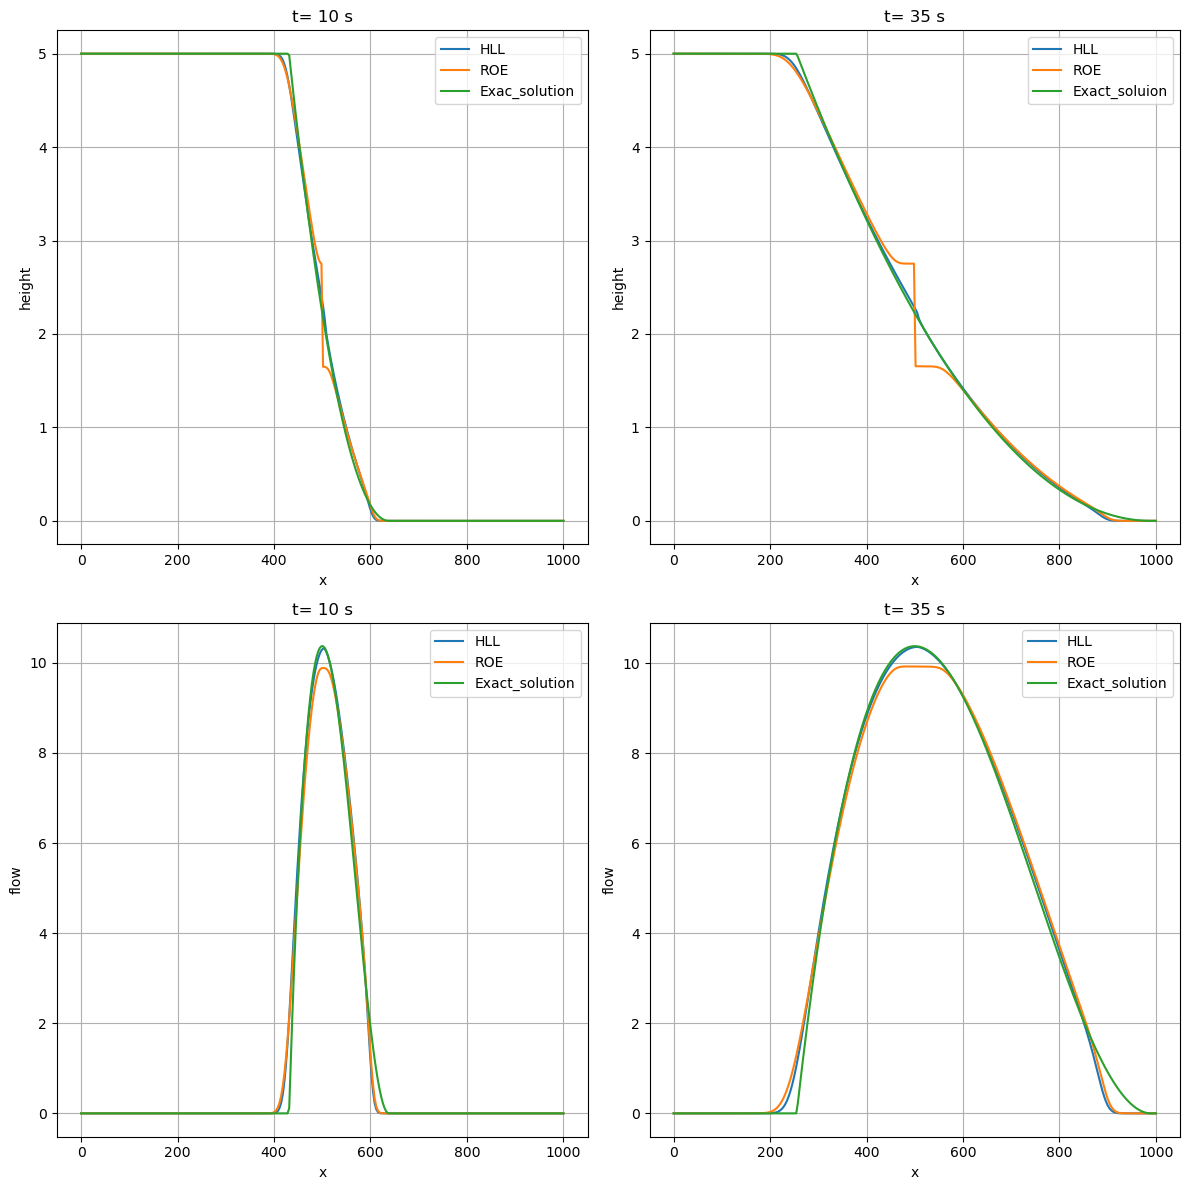

In [3]:
import matplotlib.pyplot as plt

def plot_curve(ax, x, curves, title, label1, label2, label3, ylabel):
    ax.plot(x, curves[0], label=label1)
    ax.plot(x, curves[1], label=label2)
    ax.plot(x, curves[2], label=label3)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Exemple de données (à remplacer par vos simulations)
Tfinals = [10, 35]
h_HLL, u_HLL, q_HLL, x = simulate_convection_HLL(Tfinal=Tfinals[0])
h_ROE, u_ROE, q_ROE, x, unewx, hnewx, qnewx = simulate_convection_with_ROE(Tfinal=Tfinals[0])

# Colonne 1
plot_curve(axs[0, 0], x, [h_HLL, h_ROE, hnewx], 't= 10 s', label1='HLL', label2='ROE', label3='Exac_solution', ylabel='height') # courbe des Hauteurs
plot_curve(axs[1, 0], x, [q_HLL, q_ROE, qnewx], 't= 10 s', label1='HLL', label2='ROE', label3='Exact_solution', ylabel='flow') 

h_HLL, u_HLL, q_HLL, x = simulate_convection_HLL(Tfinal=Tfinals[1])
h_ROE, u_ROE, q_ROE, x, unewx, hnewx, qnewx = simulate_convection_with_ROE(Tfinal=Tfinals[1])

# Colonne 2
plot_curve(axs[0, 1], x, [h_HLL, h_ROE, hnewx], 't= 35 s', label1='HLL', label2='ROE', label3='Exact_soluion', ylabel='height') # courbe des Hauteurs
plot_curve(axs[1, 1], x, [q_HLL, q_ROE, qnewx], 't= 35 s', label1='HLL', label2='ROE', label3='Exact_solution', ylabel='flow') 
plt.savefig('SV_fin.png')
# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_convection_with_ROE(a=0, b=1000, N=300, CFL=0.6, Tfinal=10):
    # Paramètres du domaine
    dx = (b - a) / (N - 1)
    x = np.linspace(a, b, N)

    # Initialisation de la solution u et h
    u = np.zeros(N)
    h = np.zeros(N)
    q = np.zeros(N)
    unewx=np.zeros(N)
    hnewx=np.zeros(N)
    qnewx=np.zeros(N)
    unewp=np.zeros(N)
    hnewp=np.zeros(N)
    qnewp=np.zeros(N)

    # Fonction pour la condition initiale de la hauteur h (rupture du barrage)
    def f(x):
        if 0 <= x <= 500:
            return 5 # Hauteur de l'eau avant la rupture
        else:
            return 1 # Hauteur de l'eau après la rupture

    # Initialisation de la condition initiale
    for i in range(N):
        h[i] = f(x[i])

    g = 9.81  # Accélération due à la gravité
    temps = 0
    hm=2.534
    um=4.03
    speed=np.sqrt(((g*hm)/2)*(hm+1))

    while temps < Tfinal:
        # Calcul du pas de temps pour assurer la stabilité
        s_1 = np.abs(u + np.sqrt(g * h))
        s_2 = np.abs(u - np.sqrt(g * h))
        S_1max = max(s_1)
        S_2max = max(s_2)
        max_u = max(S_1max, S_2max)

        dt = CFL * dx / max_u
        lamda = dt / dx
        #mise a jour solution exacte 
        for i in range(N):
            if x[i]<=(500-temps*np.sqrt(g*5)):
                hnewx[i]= 5
                unewx[i]= 0
            
            else:
                if (500-temps*np.sqrt(g*5))<x[i]<=(500+(um-np.sqrt(g*hm))*temps):
                    unewx[i]= (2/3)*(np.sqrt(g*5)+(x[i]-500)/temps)
                    hnewx[i]= (1/(9*g))*((2*np.sqrt(g*5)-(x[i]-500)/temps)**2)
                elif (500+(um-np.sqrt(g*hm))*temps)<x[i]<(500+temps*speed):
                    hnewx[i]= hm
                    unewx[i]= um
                else:
                    hnewx[i]= 1
                    unewx[i]= 0


        # Mise à jour de la solution numérique
        for i in range(1, N - 1):
            h_tild_r = (h[i] + h[i + 1]) / 2
            if h[i] == 0 and h[i + 1] == 0:
                u_tild_r = 0
            else:
                u_tild_r = ((np.sqrt(h[i]) * u[i] + np.sqrt(h[i + 1]) * u[i + 1]) / (np.sqrt(h[i]) + np.sqrt(h[i + 1])))

            y = np.zeros(2)
            P = np.ones((2, 2))
            D = np.zeros((2, 2))
            PI = np.ones((2, 2))

            y[0] = h[i + 1] - h[i]
            y[1] = h[i + 1] * u[i + 1] - h[i] * u[i]

            P[1][0] = u_tild_r - np.sqrt(g * h_tild_r)
            P[1][1] = u_tild_r + np.sqrt(g * h_tild_r)

            D[0][0] = np.abs(u_tild_r - np.sqrt(g * h_tild_r))
            D[1][1] = np.abs(u_tild_r + np.sqrt(g * h_tild_r))

            PI[0][0] = u_tild_r + np.sqrt(g * h_tild_r)
            PI[1][0] = np.sqrt(g * h_tild_r) - u_tild_r
            PI[0][1] = -1

            A = np.dot(P, np.dot(D, np.dot(PI, y)))

            if h_tild_r == 0:
                flux_right_h = 0
                flux_right_u = 0
            else:
                flux_right_h = 1 / 2 * (u[i] * h[i] + u[i + 1] * h[i + 1]) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[0]
                flux_right_u = 1 / 2 * ((u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2 + (u[i + 1] ** 2) * h[i + 1] + (
                            1 / 2) * g * h[i + 1] ** 2) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[1]

            h_tild_r = (h[i - 1] + h[i]) / 2
            if h[i] == 0 and h[i - 1] == 0:
                u_tild_r = 0
            else:
                u_tild_r = ((np.sqrt(h[i - 1]) * u[i - 1] + np.sqrt(h[i]) * u[i]) / (
                            np.sqrt(h[i - 1]) + np.sqrt(h[i])))

            y[0] = h[i] - h[i - 1]
            y[1] = h[i] * u[i] - h[i - 1] * u[i - 1]

            P[1][0] = u_tild_r - np.sqrt(g * h_tild_r)
            P[1][1] = u_tild_r + np.sqrt(g * h_tild_r)

            D[0][0] = np.abs(u_tild_r - np.sqrt(g * h_tild_r))
            D[1][1] = np.abs(u_tild_r + np.sqrt(g * h_tild_r))

            PI[0][0] = u_tild_r + np.sqrt(g * h_tild_r)
            PI[1][0] = np.sqrt(g * h_tild_r) - u_tild_r
            PI[0][1] = -1

            A = np.dot(P, np.dot(D, np.dot(PI, y)))

            if h_tild_r == 0:
                flux_left_h = 0
                flux_left_u = 0
            else:
                flux_left_h = 1 / 2 * (u[i - 1] * h[i - 1] + u[i] * h[i]) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[0]
                flux_left_u = 1 / 2 * ((u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2 + (u[i] ** 2) * h[i] + (
                            1 / 2) * g * h[i] ** 2) - (1 / (4 * np.sqrt(g * h_tild_r))) * A[1]

            hnewp[i] = h[i] - lamda * (flux_right_h - flux_left_h)
            if hnewp[i] == 0:
                unewp[i] = 0
            else:
                unewp[i] = (1 / hnewp[i]) * (h[i] * u[i] - lamda * (flux_right_u - flux_left_u))

        # Conditions aux limites de Neumann (Dérivées nulles)
        hnewp[N - 1] = hnewp[N - 2]
        hnewp[0] = hnewp[1]
        unewp[N - 1] = unewp[N - 2]
        unewp[0] = unewp[1]

        for i in range(N):
            q[i] = h[i] * u[i]
            qnewx[i]=hnewx[i]*unewx[i]

        # Mise à jour du temps
        temps += dt

        # Mise à jour de u et h
        u = unewp.copy()
        h = hnewp.copy()

    # Retourner les valeurs finales de h, u, q, x
    return h, u, q, x,unewx,hnewx,qnewx

# Fonction pour tracer une courbe donnée




In [9]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_convection_HLL(a=0, b=1000, N=300, CFL=0.6, Tfinal=10):
    # Paramètres du domaine
    dx = (b - a) / (N - 1)
    x = np.linspace(a, b, N)

    # Initialisation de la solution u et h
    u = np.zeros(N)
    h = np.zeros(N)
    q = np.zeros(N)
    qnewp = np.zeros(N)
    unewp=np.zeros(N)
    hnewp=np.zeros(N)
  

    # Fonction pour la condition initiale de la hauteur h (rupture du barrage)
    def f(x):
        if 0 <= x <= 500:
            return 5  # Hauteur de l'eau avant la rupture
        else:
            return 1 # Hauteur de l'eau après la rupture

    # Initialisation de la condition initiale
    for i in range(N):
        h[i] = f(x[i])

    g = 9.81  # Accélération due à la gravité
    temps = 0

    while temps < Tfinal:
        # Calcul du pas de temps pour assurer la stabilité
        s_1 = np.abs(u + np.sqrt(g * h))
        s_2 = np.abs(u - np.sqrt(g * h))
        S_1max = max(s_1)
        S_2max = max(s_2)
        max_u = max(S_1max, S_2max)

        dt = CFL * dx / max_u
        lamda = dt / dx

        # Mise à jour de la solution numérique
        for i in range(1, N - 1):
            S_RR = max(u[i + 1] + np.sqrt(g * h[i + 1]), u[i] + np.sqrt(g * h[i]))
            S_LR = min(u[i + 1] - np.sqrt(g * h[i + 1]), u[i] - np.sqrt(g * h[i]))

            if S_RR == S_LR:
                if S_LR > 0:
                    flux_right_h = u[i] * h[i]
                    flux_right_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2
                elif S_RR == 0:
                    flux_right_h = 0
                    flux_right_u = 0
                else:
                    flux_right_h = u[i + 1] * h[i + 1]
                    flux_right_u = (u[i + 1] ** 2) * h[i + 1] + (1 / 2) * g * h[i + 1] ** 2
            else:
                if S_LR > 0:
                    flux_right_h = u[i] * h[i]
                    flux_right_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2
                elif S_LR <= 0 <= S_RR:
                    flux_right_h = (S_RR * u[i] * h[i] - S_LR * u[i + 1] * h[i + 1] + S_LR * S_RR * (h[i + 1] - h[i])) / (
                                S_RR - S_LR)
                    flux_right_u = (S_RR * ((u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2) -
                                    S_LR * ((u[i + 1] ** 2) * h[i + 1] + (1 / 2) * g * h[i + 1] ** 2) +
                                    S_LR * S_RR * (u[i + 1] - u[i])) / (S_RR - S_LR)
                else:
                    flux_right_h = u[i + 1] * h[i + 1]
                    flux_right_u = (u[i + 1] ** 2) * h[i + 1] + (1 / 2) * g * h[i + 1] ** 2

            S_RL = max(u[i] + np.sqrt(g * h[i]), u[i - 1] + np.sqrt(g * h[i - 1]))
            S_LL = min(u[i - 1] - np.sqrt(g * h[i - 1]), u[i] - np.sqrt(g * h[i]))

            if S_RL == S_LL:
                if S_LL > 0:
                    flux_left_h = u[i - 1] * h[i - 1]
                    flux_left_u = (u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2
                elif S_RL == 0:
                    flux_left_h = 0
                    flux_left_u = 0
                else:
                    flux_left_h = u[i] * h[i]
                    flux_left_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2
            else:
                if S_LL > 0:
                    flux_left_h = u[i - 1] * h[i - 1]
                    flux_left_u = (u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2
                elif S_LL <= 0 <= S_RL:
                    flux_left_h = (S_RL * u[i - 1] * h[i - 1] - S_LL * u[i] * h[i] + S_LL * S_RL * (h[i] - h[i - 1])) / (
                                S_RL - S_LL)
                    flux_left_u = (S_RL * ((u[i - 1] ** 2) * h[i - 1] + (1 / 2) * g * h[i - 1] ** 2) -
                                   S_LL * ((u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2) +
                                   S_LL * S_RL * (u[i] - u[i - 1])) / (S_RL - S_LL)
                else:
                    flux_left_h = u[i] * h[i]
                    flux_left_u = (u[i] ** 2) * h[i] + (1 / 2) * g * h[i] ** 2

            hnewp[i] = h[i] - lamda * (flux_right_h - flux_left_h)
            if hnewp[i] == 0:
                unewp[i] = 0
            else:
                unewp[i] = (1 / hnewp[i]) * (h[i] * u[i] - lamda * (flux_right_u - flux_left_u))

        # Conditions aux limites de Neumann (Dérivées nulles)
        hnewp[N - 1] = hnewp[N - 2]
        hnewp[0] = hnewp[1]
        unewp[N - 1] = unewp[N - 2]
        unewp[0] = unewp[1]

        for i in range(N):
            qnewp[i] = hnewp[i] * unewp[i]

        # Mise à jour du temps
        temps += dt

        # Mise à jour de u et h
        u = unewp.copy()
        h = hnewp.copy()
        q = qnewp.copy()

    # Retourner les valeurs finales de h, u, q, x
    return h, u, q, x


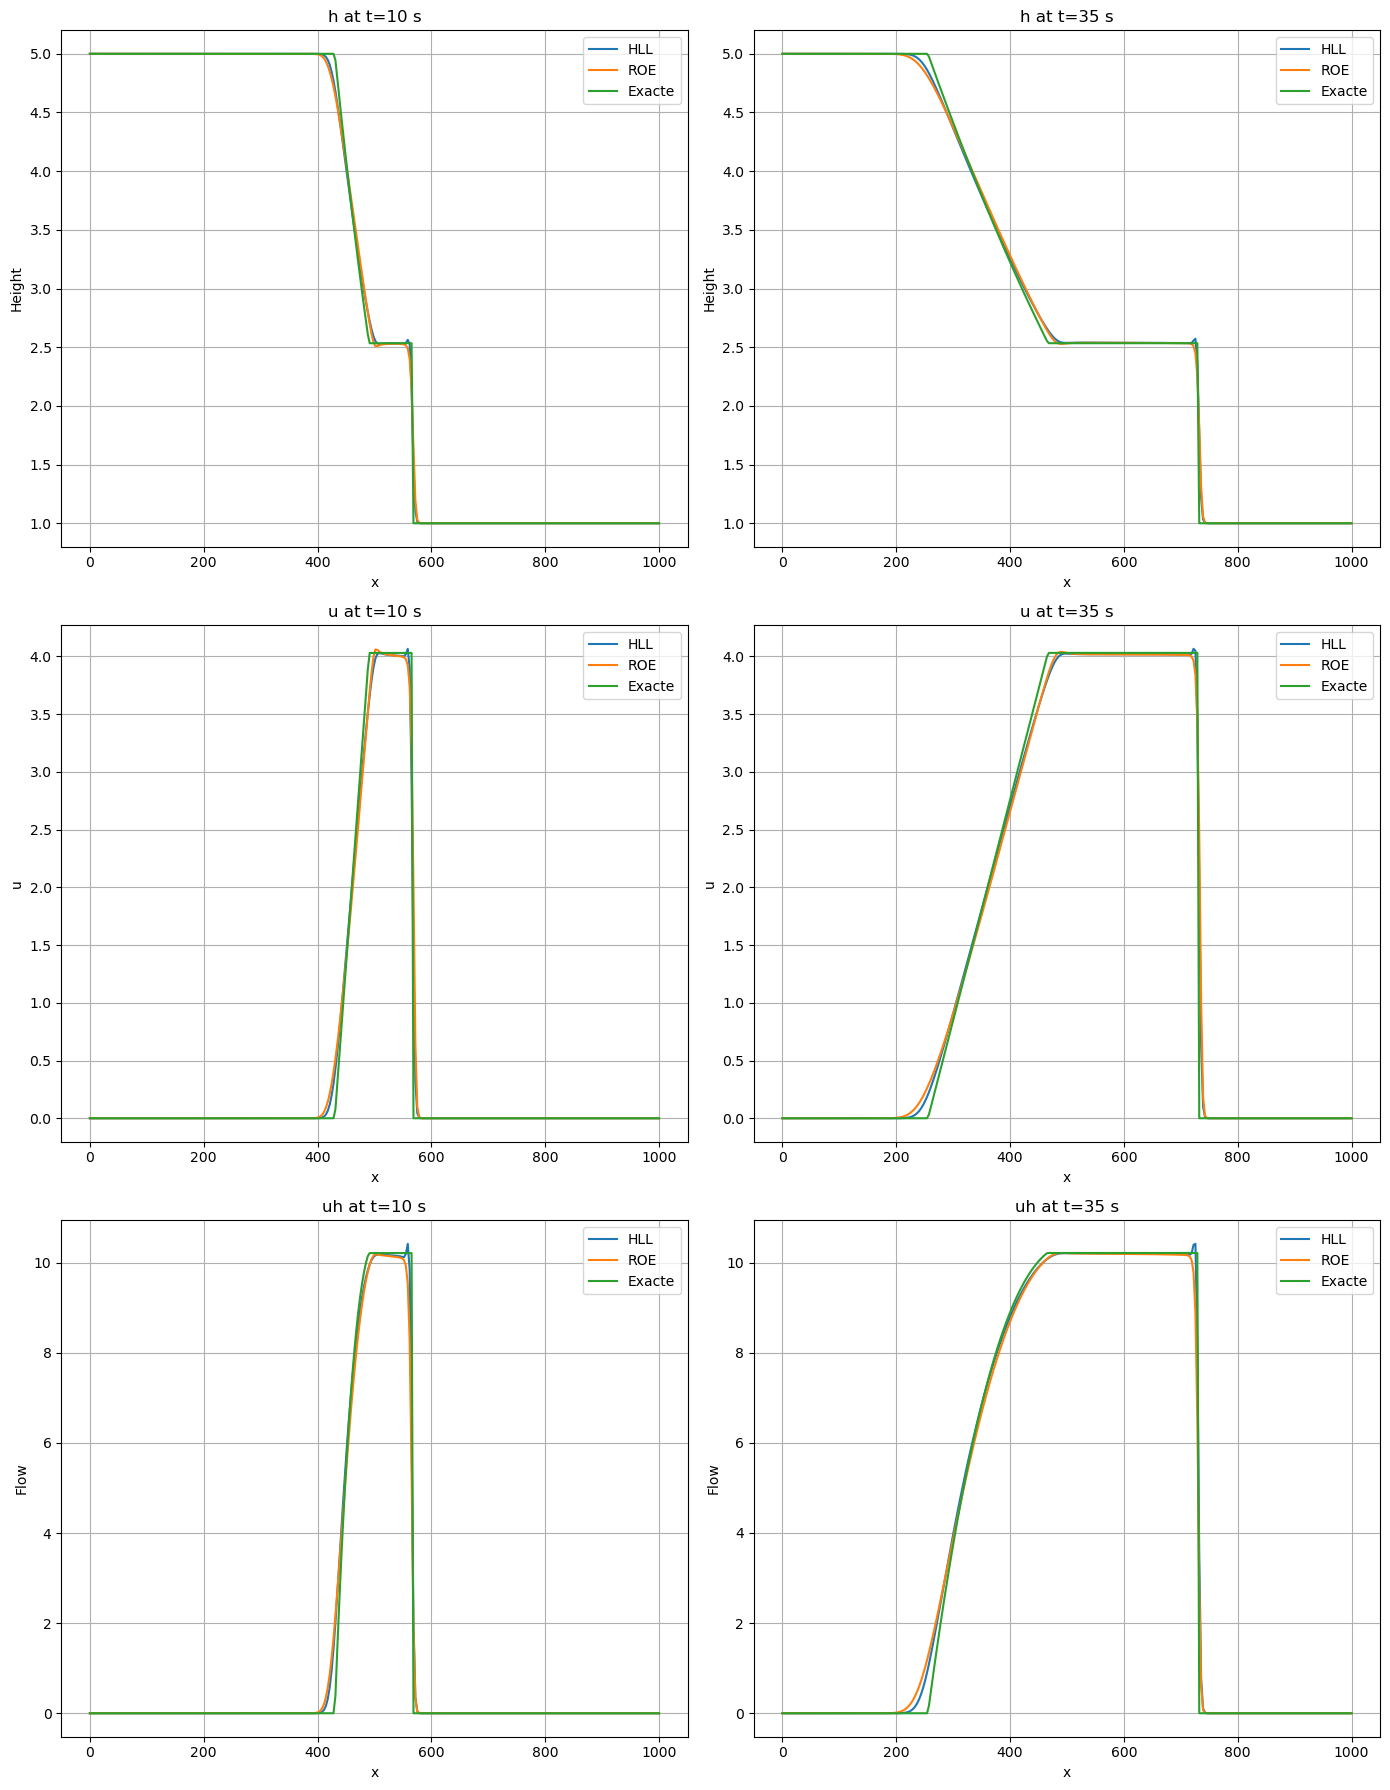

In [12]:
import matplotlib.pyplot as plt

def plot_curve(ax, x, curves, title, labels, ylabel):
    for curve, label in zip(curves, labels):
        ax.plot(x, curve, label=label)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Exemple de données (à remplacer par vos simulations)
Tfinals = [10, 35]
h_HLL_10, u_HLL_10, q_HLL_10, x = simulate_convection_HLL(Tfinal=Tfinals[0])
h_ROE_10, u_ROE_10, q_ROE_10, x, unewx_10, hnewx_10, qnewx_10 = simulate_convection_with_ROE(Tfinal=Tfinals[0])

h_HLL_25, u_HLL_25, q_HLL_25, x = simulate_convection_HLL(Tfinal=Tfinals[1])
h_ROE_25, u_ROE_25, q_ROE_25, x, unewx_25, hnewx_25, qnewx_25 = simulate_convection_with_ROE(Tfinal=Tfinals[1])

# Ligne 1 : Hauteur
plot_curve(axs[0, 0], x, [h_HLL_10, h_ROE_10, hnewx_10], 'h at t=10 s', ['HLL', 'ROE', 'Exacte'], 'Height')
plot_curve(axs[0, 1], x, [h_HLL_25, h_ROE_25, hnewx_25], 'h at t=35 s', ['HLL', 'ROE', 'Exacte'], 'Height')

# Ligne 2 : u
plot_curve(axs[1, 0], x, [u_HLL_10, u_ROE_10, unewx_10], 'u at t=10 s', ['HLL', 'ROE', 'Exacte'], 'u')
plot_curve(axs[1, 1], x, [u_HLL_25, u_ROE_25, unewx_25], 'u at t=35 s', ['HLL', 'ROE', 'Exacte'], 'u')

# Ligne 3 : q
plot_curve(axs[2, 0], x, [q_HLL_10, q_ROE_10, qnewx_10], 'uh at t=10 s', ['HLL', 'ROE', 'Exacte'], 'Flow')
plot_curve(axs[2, 1], x, [q_HLL_25, q_ROE_25, qnewx_25], 'uh at t=35 s', ['HLL', 'ROE', 'Exacte'], 'Flow')
plt.savefig('SV_C2.png')
# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

